In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def fix_weights_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_weights(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model
    

def brute_force_analysis_weights(model, layer_names, bw_range, f_range, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [12]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None, name=None):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])
    if name:
        plt.savefig(f'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Brute force results/{name}.png', 
                    bbox_inches='tight')

In [2]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Weights/Keras_CIFAR10/'
bw_range = np.arange(1, 11, 1)
f_range = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
vmax=0.1

# CIFAR10

## Quantizing Weights

In [5]:
name = 'cifar_keras'
model_path = 'cifar_keras/cifar_keras_new.h5'

from test_models.cifar_keras import data
_, test_data = data.get_data()

keras_cifar = model_data.Model(name, test_data, path=save_path + model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Forward quantization

In [ ]:
scores_ = brute_force_analysis_weights(keras_cifar, layer_names, bw_range, f_range)
np.save(output_path + 'scores_1_w', arr=scores_)

In [6]:
parameters = {'conv2d_1': [6, 7]}

scores_1_1 = brute_force_analysis_weights(keras_cifar, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [7, 8]}
scores_1_2 = brute_force_analysis_weights(keras_cifar, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [8, 9]}
scores_1_3 = brute_force_analysis_weights(keras_cifar, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [9, 10]}
scores_1_4 = brute_force_analysis_weights(keras_cifar, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_1_1', scores_1_1)
np.save(output_path + 'scores_1_2', scores_1_2)
np.save(output_path + 'scores_1_3', scores_1_3)
np.save(output_path + 'scores_1_4', scores_1_4)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [30]:
parameters = {
    'conv2d_1': [9, 10],
    'conv2d_2': [6, 7]
}
scores_2 = brute_force_analysis_weights(keras_cifar, layer_names[2:], bw_range, f_range,
                                fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_2', arr=scores_2)

Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [34]:
parameters = {
    'conv2d_1': [9, 10],
    'conv2d_2': [6, 7],
    'conv2d_3': [4, 5]
}
scores_3 = brute_force_analysis_weights(keras_cifar, layer_names[3:], bw_range, f_range,
                               fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_3', arr=scores_3)

Layer conv2d_4 done.


Layer dense_1 done.


In [40]:
parameters = {
    'conv2d_1': [9, 10],
    'conv2d_2': [6, 7],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5]
}
scores_4 = brute_force_analysis_weights(keras_cifar, layer_names[4:], bw_range, f_range,
                               fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_4', arr=scores_4)

Layer dense_1 done.


In [3]:
# Use this cell to load scores for plotting if scores are saved
scores_ = np.load(output_path + 'scores_1_w.npy')
scores_1_1 = np.load(output_path + 'scores_1_1.npy')
scores_1_2 = np.load(output_path + 'scores_1_2.npy')
scores_1_3 = np.load(output_path + 'scores_1_3.npy')
scores_1_4 = np.load(output_path + 'scores_1_4.npy')
scores_2 = np.load(output_path + 'scores_2.npy')
scores_3 = np.load(output_path + 'scores_3.npy')
scores_4 = np.load(output_path + 'scores_4.npy')

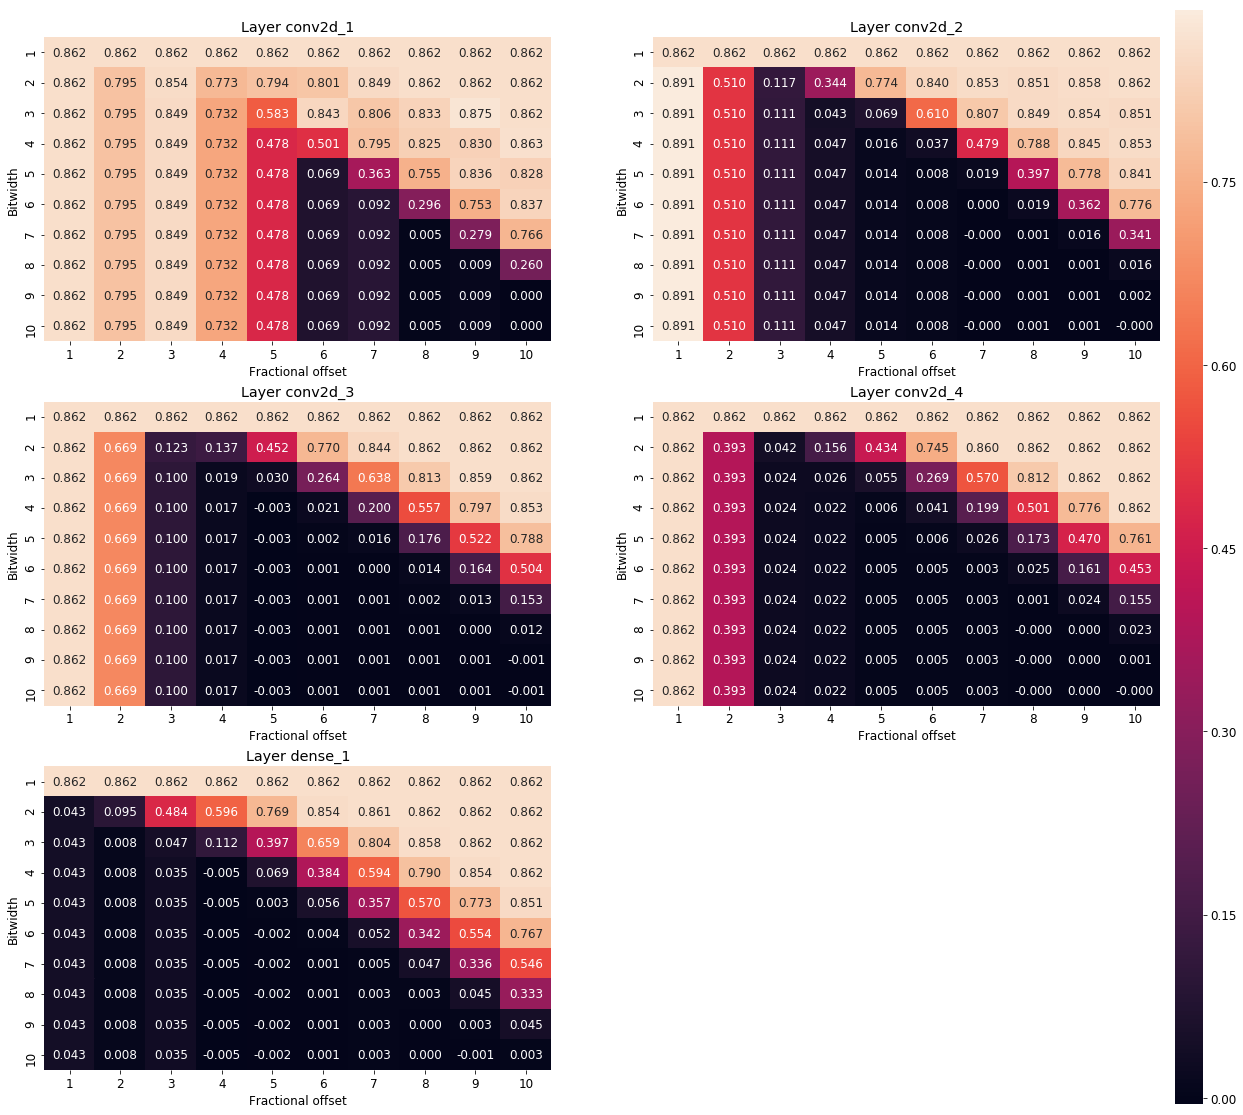

In [14]:
plot_results(scores_, layer_names, 3, 2, (20, 19), 0.8, bw_range, f_range, vmax=None, name='keras_cifar10_w')

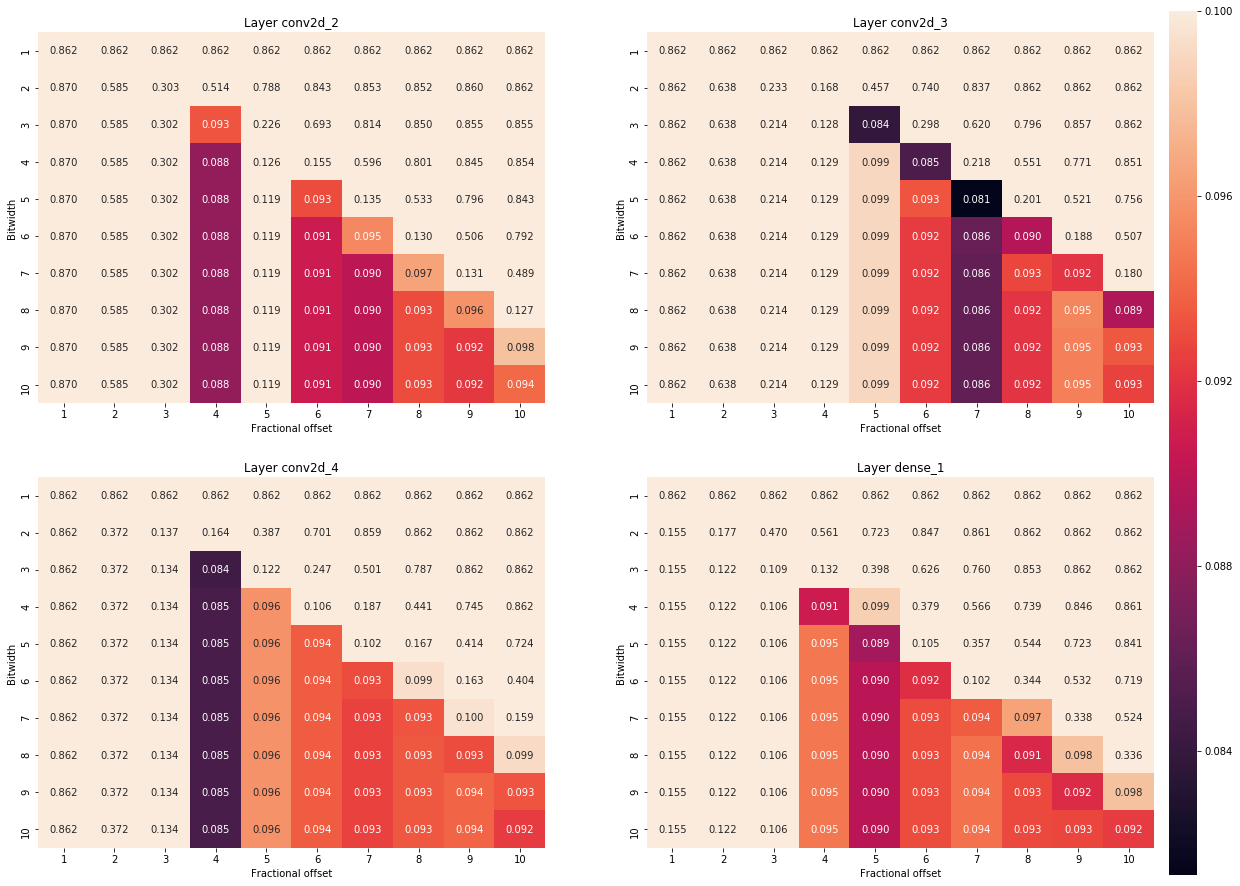

In [20]:
plot_results(scores_1_1, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

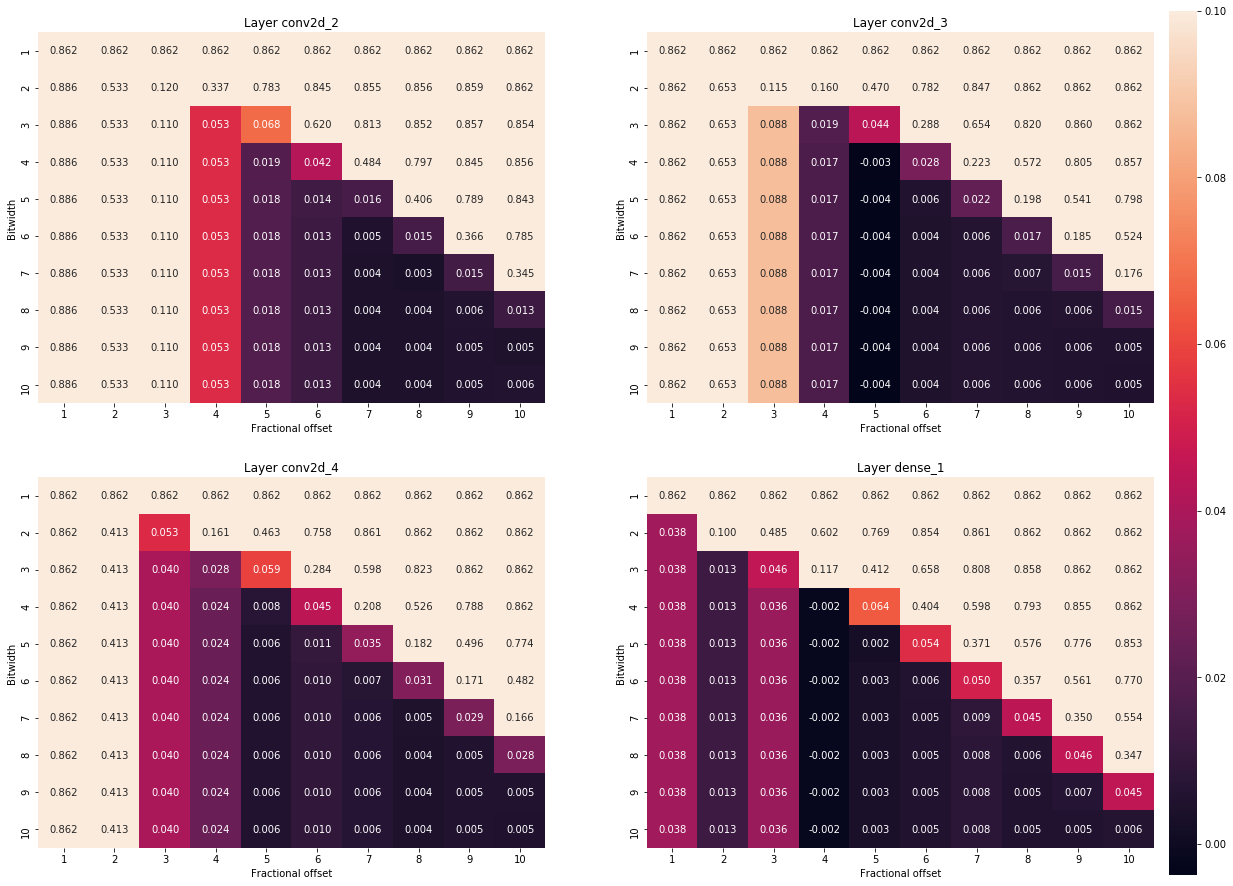

In [7]:
plot_results(scores_1_2, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

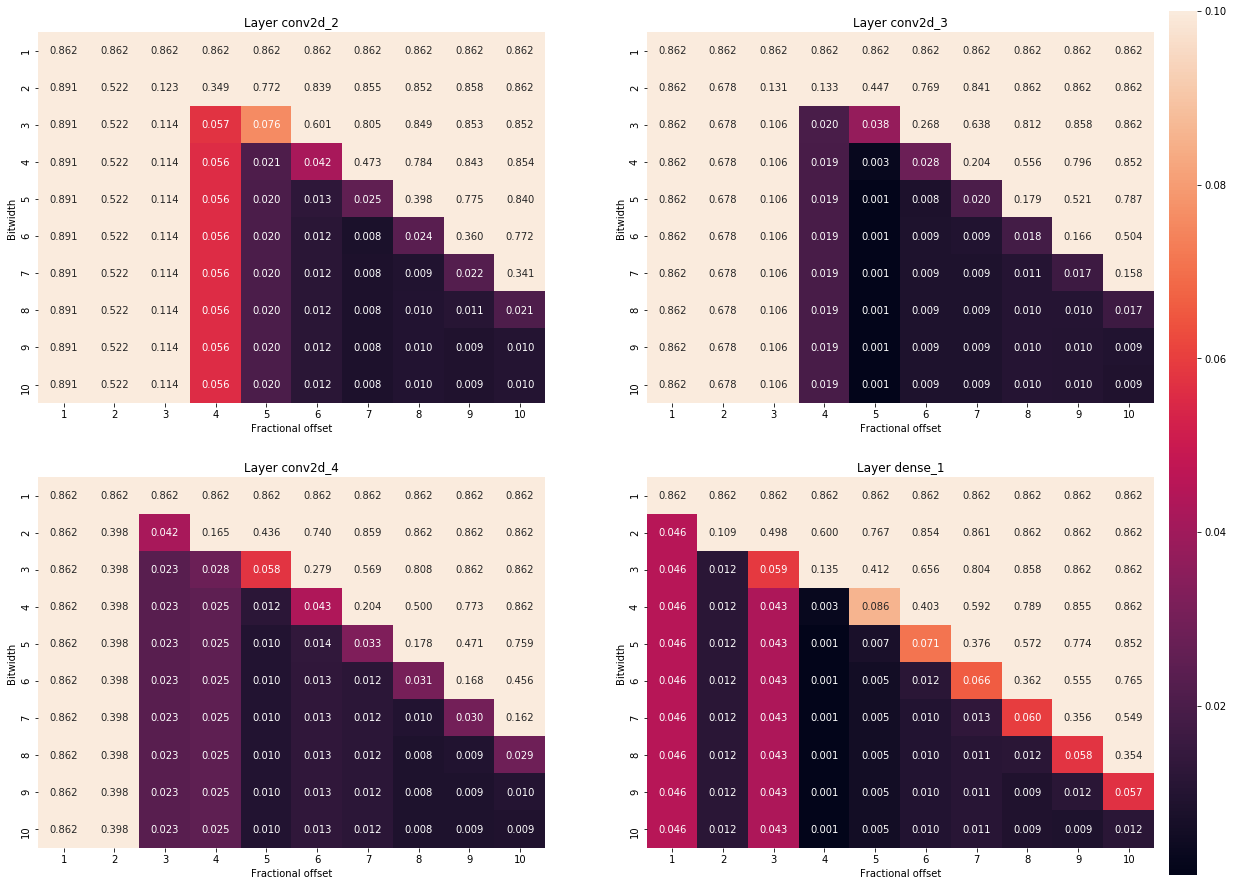

In [8]:
plot_results(scores_1_3, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

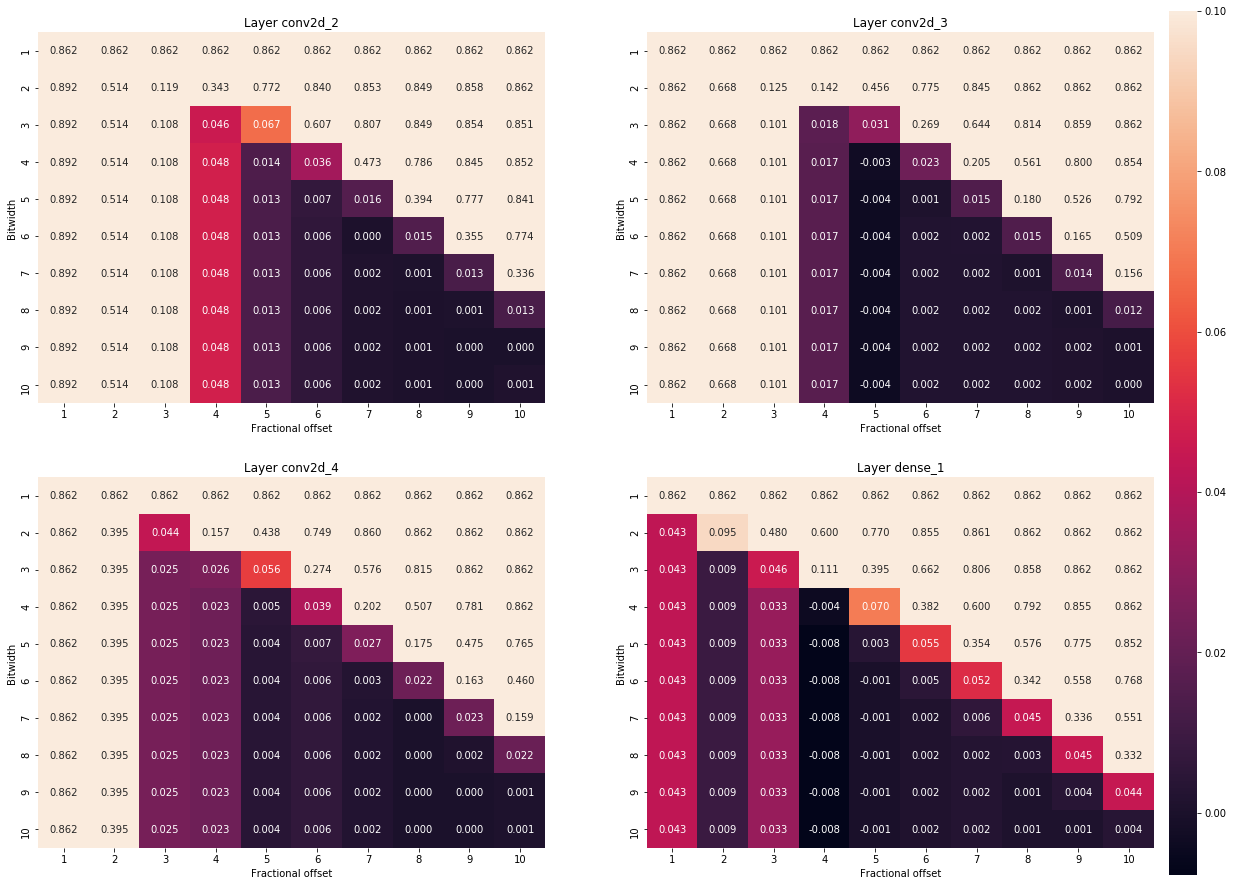

In [9]:
plot_results(scores_1_4, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

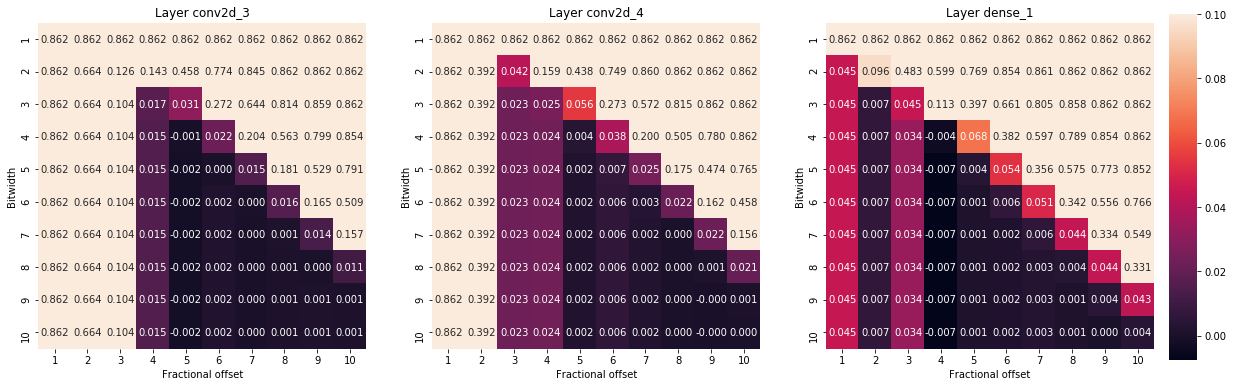

In [32]:
plot_results(scores_2, layer_names[2:], 1, 3, (20, 6), 0.8, bw_range, f_range, vmax=vmax)

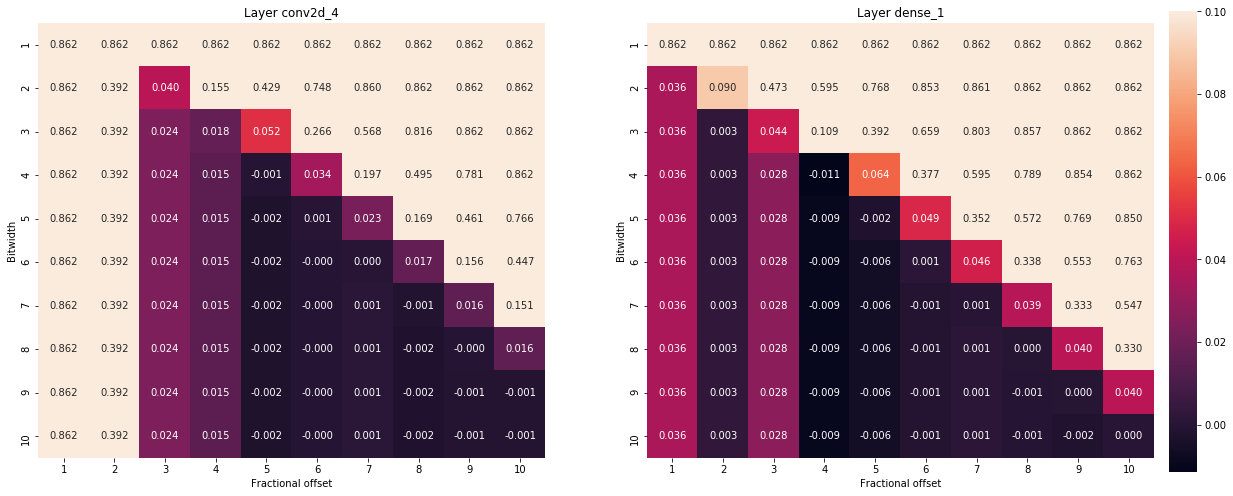

In [38]:
plot_results(scores_3, layer_names[3:], 1, 2, (20, 8), 0.8, bw_range, f_range, vmax=vmax)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


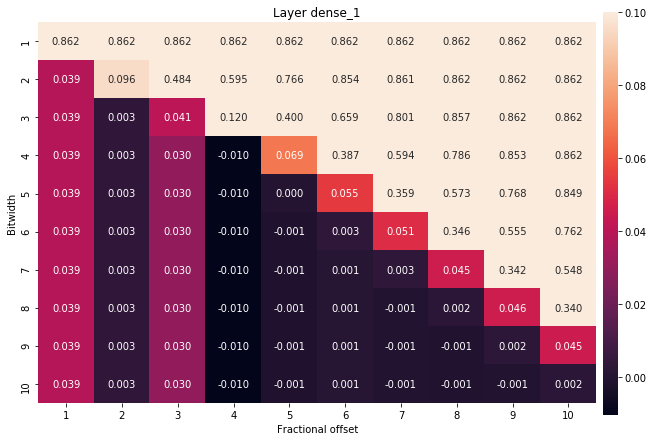

In [41]:
plot_results(scores_4, layer_names[4:], 1, 1, (10, 7), 0.8, bw_range, f_range, vmax=vmax)

#### Visualize weight distribution of final result

In [53]:
keras_cifar.load_model_from_path()
keras_cifar.evaluate_accuracy()[1]

0.7243

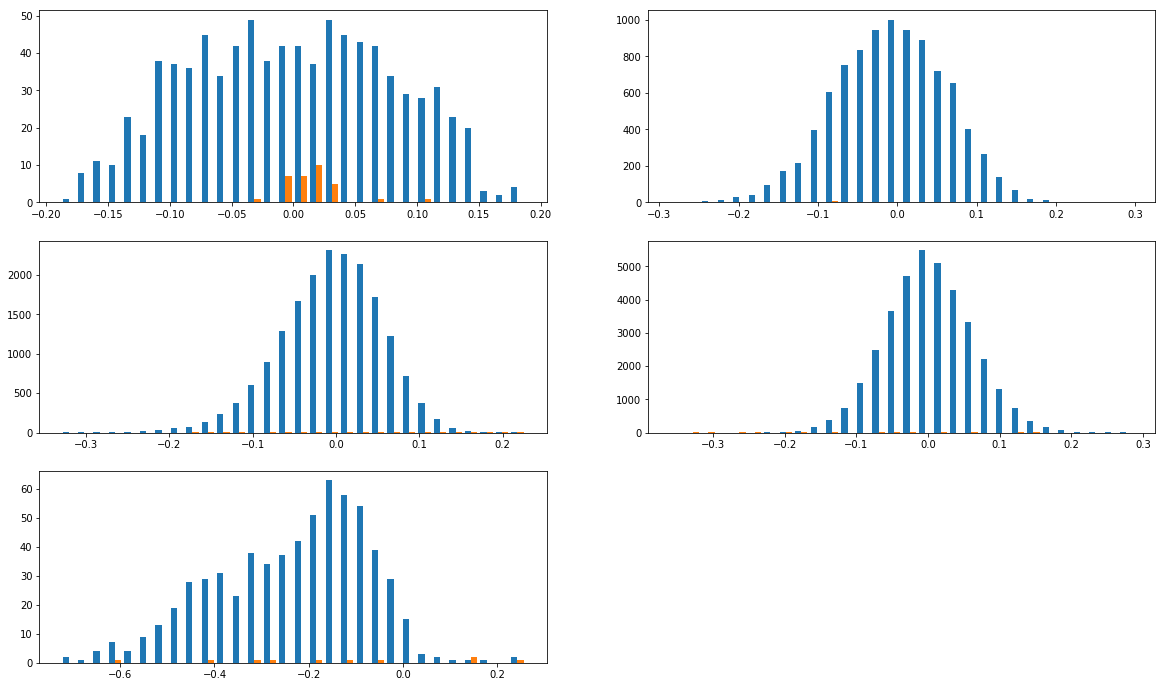

In [54]:
# original set of weights
w = keras_cifar.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [48]:
parameters = {
    'conv2d_1': [9, 10],
    'conv2d_2': [6, 7],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 4]
}
for k in parameters.keys():
    keras_cifar.model = fxp_quantize.quantize_weights(keras_cifar.model, parameters[k][0], parameters[k][1],
                                                      layer_name=[k])

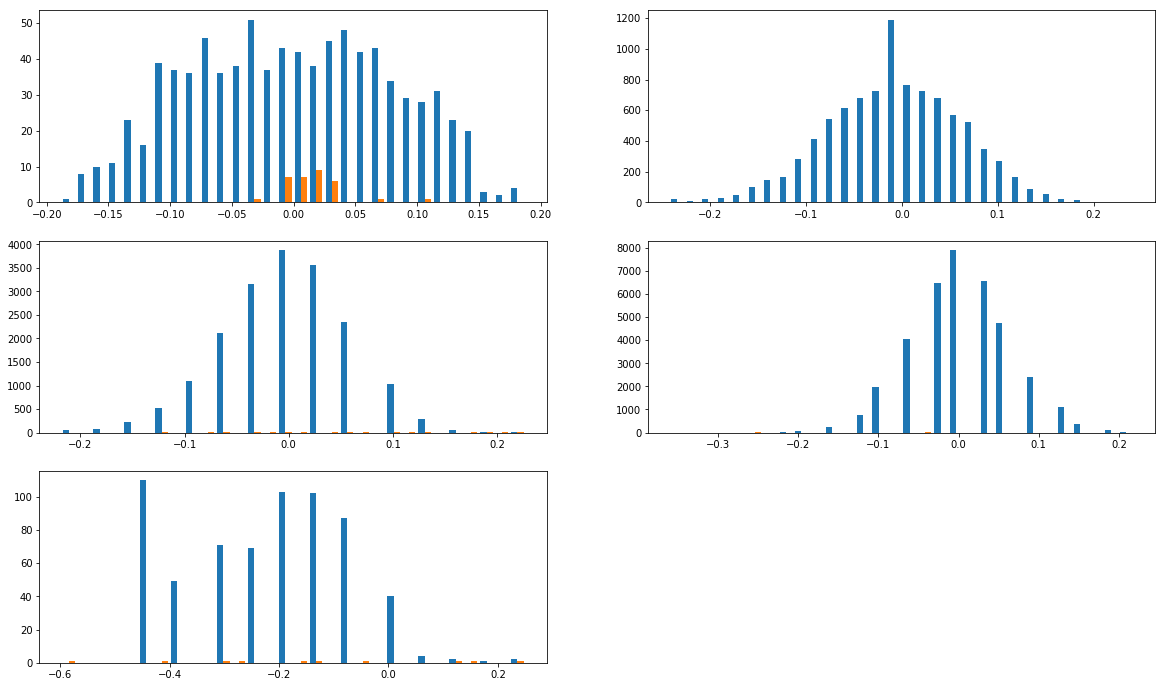

In [52]:
# Quantized set of weights
w = keras_cifar.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [49]:
keras_cifar.evaluate_accuracy()[1]

0.7316

#### Compare activation distributions before and after quantization

In [7]:
keras_cifar.load_model_from_path()
act_maps_before_quant = keras_cifar.get_activation_maps(keras_cifar.x_test[0].reshape(1, 32, 32, 3), 'conv2d_4')
parameters = {
    'conv2d_1': [9, 10],
    'conv2d_2': [6, 7],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 4]
}
for k in parameters.keys():
    keras_cifar.model = fxp_quantize.quantize_weights(keras_cifar.model, parameters[k][0], parameters[k][1],
                                                      layer_name=[k])

act_maps_after_quant = keras_cifar.get_activation_maps(keras_cifar.x_test[0].reshape(1, 32, 32, 3), 'conv2d_4')

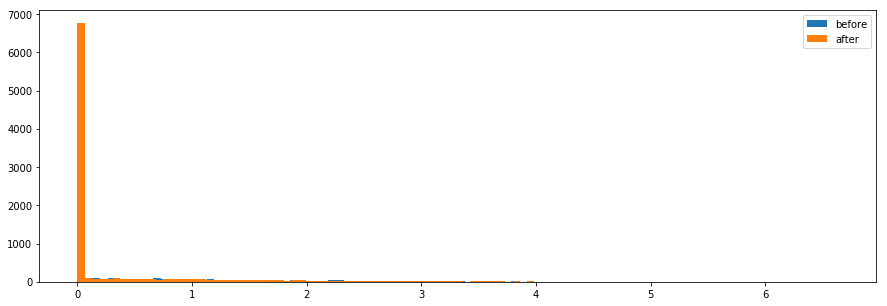

In [79]:
fig = plt.figure(figsize=(15, 5))
plt.hist(act_maps_before_quant.flat, bins=100, label='before');
plt.hist(act_maps_after_quant.flat, bins=100, label='after');
plt.legend()

Text(0.5, 1.0, 'difference in activation distributions before and after quantization')

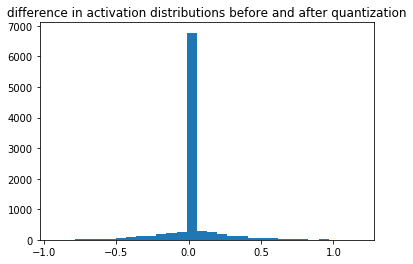

In [78]:
d = act_maps_after_quant - act_maps_before_quant
plt.hist(d.flat, bins=30);
plt.title('Difference in activation distributions before and after quantization');

##### Observations

- By using conservative quantization on each layer, conservative implying that we try and use a (BW, F) such that we maximize our inference accuracy, we can, for the most part, use the same parameters as those found from independent quantization. There are however slight differences in the values of the inference accuracy as we start to fix the quantization for each layer, which in some cases might cause the appropriate BW, F for that layer to change. 
- Harsh quantization, as seen in scores_1_1, leads to unpredictable behaviour, which we would ideally like to avoid. The quantization here was too harsh, in which we were choosing a point that resulted in a 9% drop in inference accuracy of our network.
- Applying quantization throughout the network for each layer sequentially (from input to output layer), we were able to improve on the floating point network's inference accuracy by 1%. This improvement by 1% was due to the fractional offset we chose for the dense layer. We are not entirely sure why the quantization leads to an improvement, however we can hypothesize that there is a sort of regularization effect that occurs due to quantization in this specific case. 
- The distribution of the weights after quantization will vary given that we apply quantization differently to each layer. 
- One hypothesis for the change in the inference accuracy values after fixing quantization, vs independent quantization, was that the change in the activation values would cause the next layer's input result to change, which would then affect how we quantize our weights. By comparing activation maps before and after quantization, we can see that the activations are marginally different, but for the most part are the same. The reason for this occurence is possibly future work
- Observing the distribution of the weights we can observe that the weights of the first two layers are not clipped. It seems as though the weights of the first layer are untouched. For the second layer, we start to see some minor effects of rounding. For the third, we see clipping and rounding, and so on.

#### Check differences

Observe the differences in the heatmaps against their independent quantization heatmaps

In [82]:
diff_1_1 = np.abs(scores_[:, :, 1] - scores_1_1[:, :, 0])
diff_1_2 = np.abs(scores_[:, :, 1] - scores_1_2[:, :, 0])
diff_1_3 = np.abs(scores_[:, :, 1] - scores_1_3[:, :, 0])
diff_1_4 = np.abs(scores_[:, :, 1] - scores_1_4[:, :, 0])
diff_2 = np.abs(scores_[:, :, 2] - scores_2[:, :, 0])
diff_3 = np.abs(scores_[:, :, 3] - scores_3[:, :, 0])
diff_4 = np.abs(scores_[:, :, 4] - scores_4)

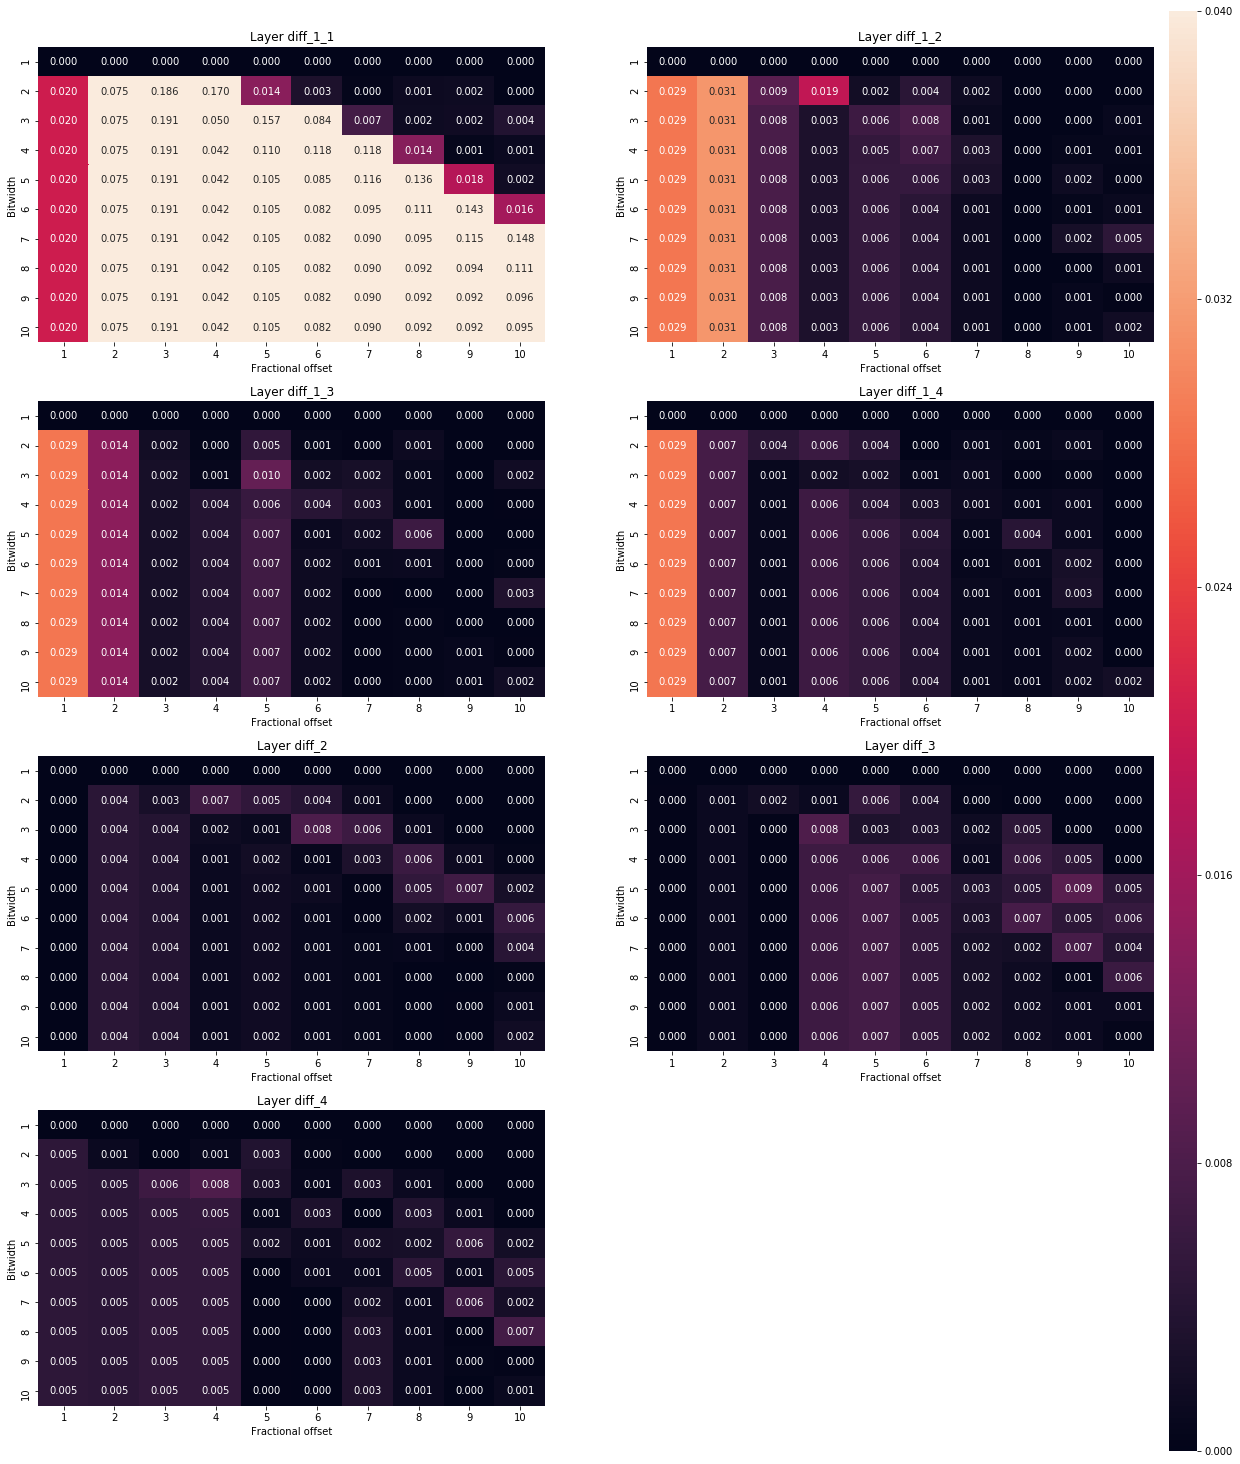

In [86]:
diff = np.dstack((diff_1_1, diff_1_2, diff_1_3, diff_1_4, diff_2, diff_3, diff_4))
names = ['diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_1_4', 'diff_2', 'diff_3', 'diff_4']
plot_results(diff, names, 4, 2, (20, 25), 0.8, bw_range, f_range, vmax=0.04)

### Reverse Quantization

In [88]:
parameters = {
    'dense_1': [4, 4]
}
scores_r1_1 = brute_force_analysis_weights(keras_cifar, layer_names[:-1], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1_1', arr=scores_r1_1)

parameters = {
    'dense_1': [5, 5]
}
scores_r1_2 = brute_force_analysis_weights(keras_cifar, layer_names[:-1], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1_2', arr=scores_r1_2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


In [91]:
parameters = {
    'conv2d_4': [4, 5],
    'dense_1': [4, 4]
}
scores_r2 = brute_force_analysis_weights(keras_cifar, layer_names[:-2], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r2', arr=scores_r2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


In [94]:
parameters = {
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 4]
}
scores_r3 = brute_force_analysis_weights(keras_cifar, layer_names[:-3], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r3', arr=scores_r3)

Layer conv2d_1 done.


Layer conv2d_2 done.


In [95]:
parameters = {
    'conv2d_2': [6, 7],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 4]
}
scores_r4 = brute_force_analysis_weights(keras_cifar, layer_names[:-4], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r4', arr=scores_r4)

Layer conv2d_1 done.


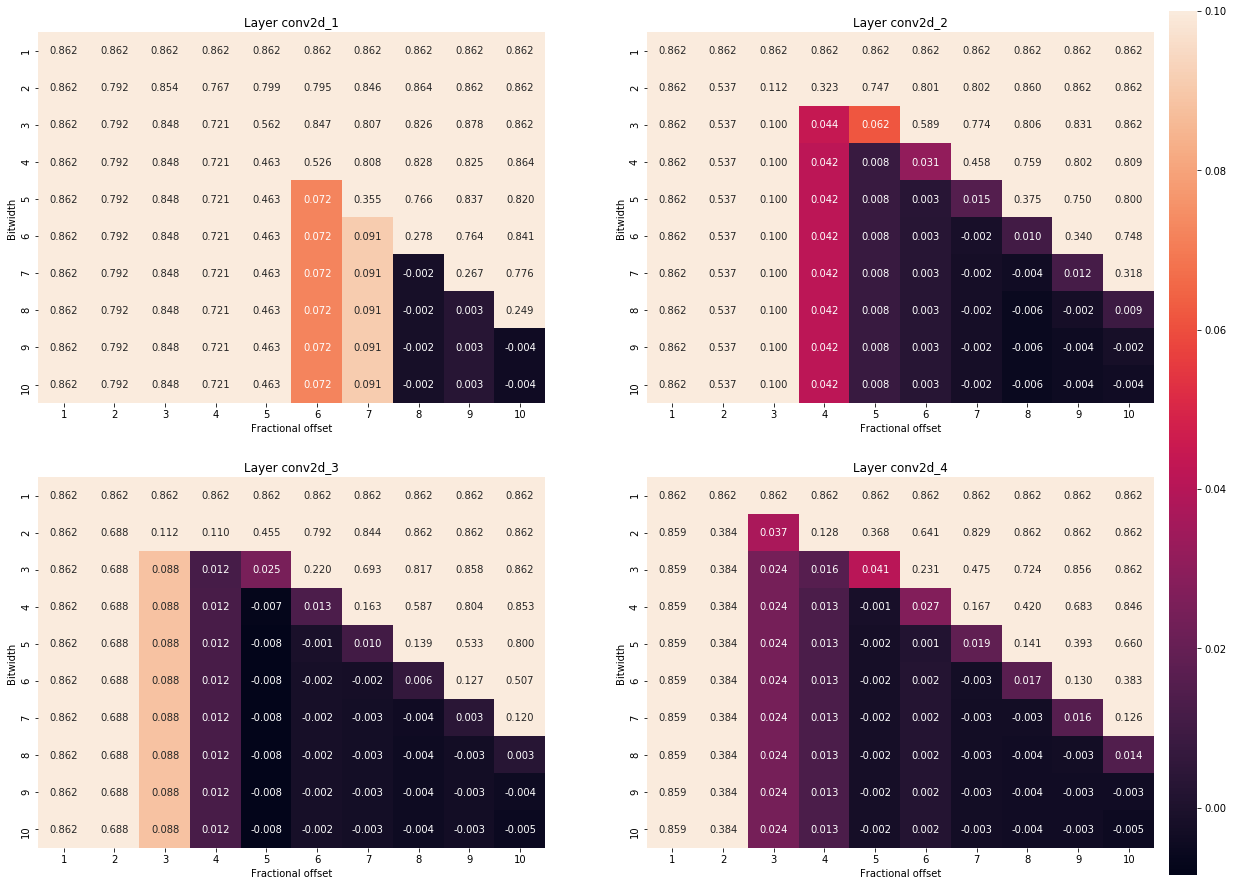

In [89]:
plot_results(scores_r1_1, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

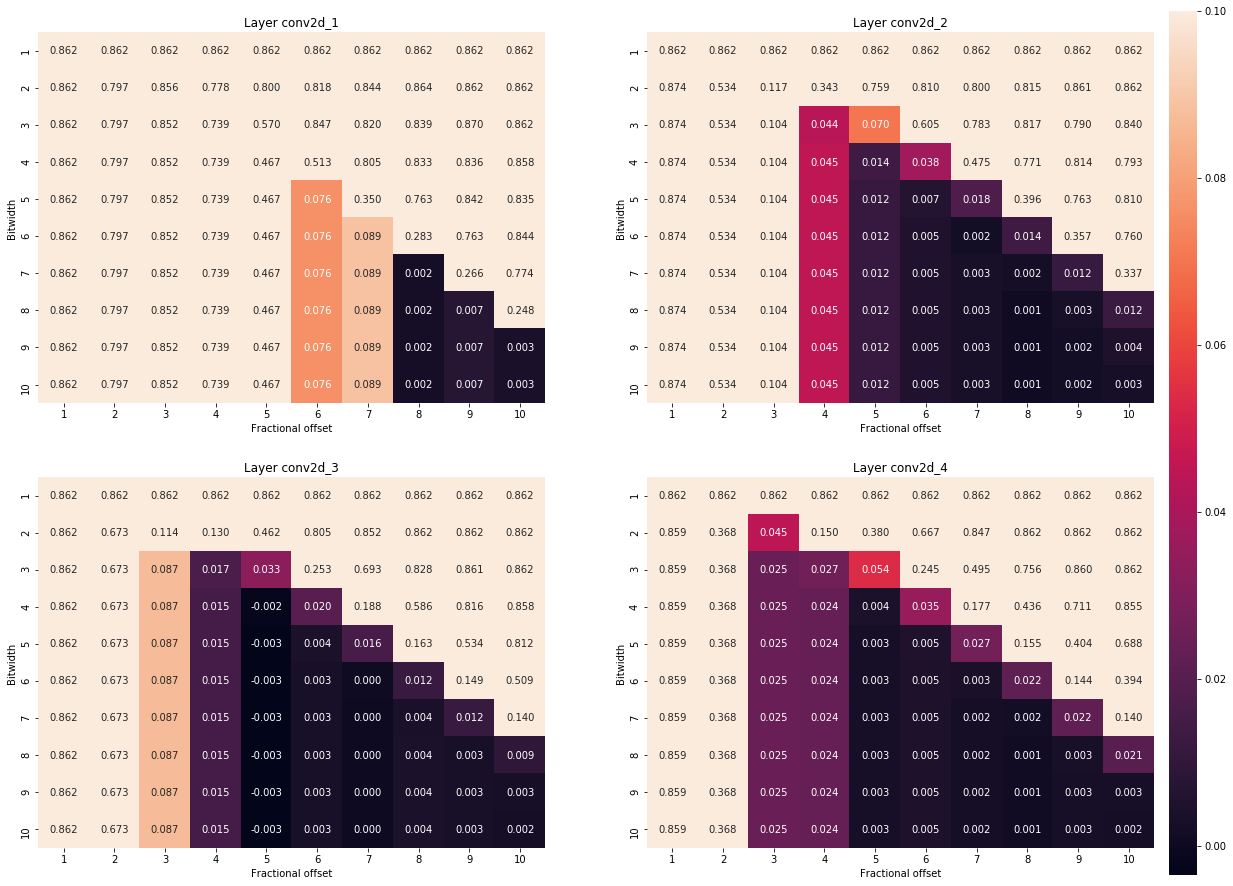

In [90]:
plot_results(scores_r1_2, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

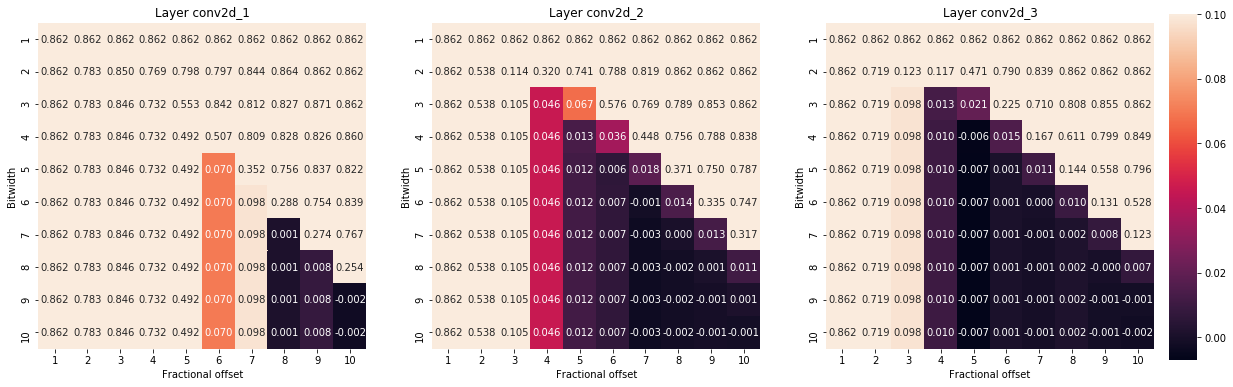

In [93]:
plot_results(scores_r2, layer_names[:-2], 1, 3, (20, 6), 0.8, bw_range, f_range, vmax=vmax)

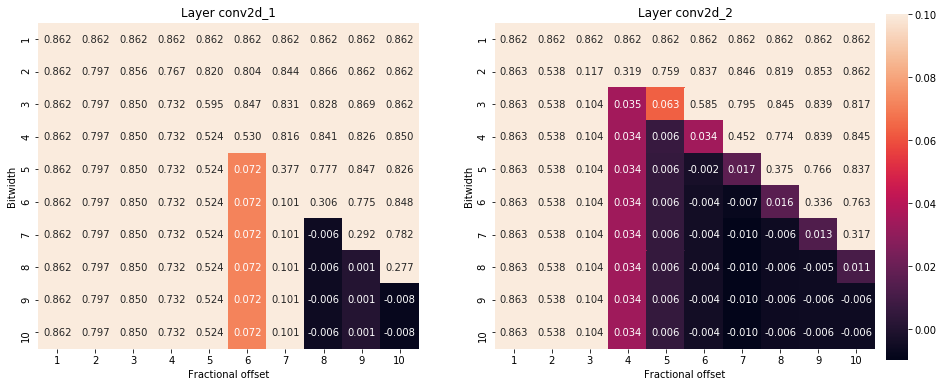

In [96]:
plot_results(scores_r3, layer_names[:-3], 1, 2, (15, 6), 0.8, bw_range, f_range, vmax=vmax)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


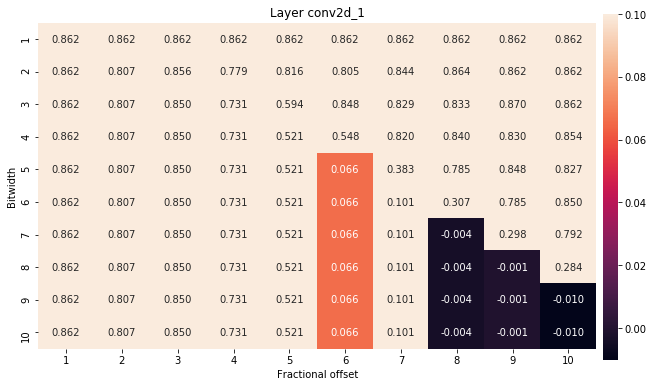

In [97]:
plot_results(scores_r4, layer_names[:-4], 1, 1, (10, 6), 0.8, bw_range, f_range, vmax=vmax)

##### Observations

- Applying reverse quantization, we can see that the parameters (BW, F) that were chosen did not differ from those chosen for forward quantization. By choosing the same set of parameters, we can see that overall, as was the case for forward quantization, our resulting quantized model now allows for a 1% improvement of inference accuracy over the floating point model. 
- Clearly, layer 1 is still very sensitive to quantization, possibly because it has the least number of parameters to be quantized.

In [8]:
keras_cifar.load_model_from_path()
print(f'Original floating point model inference accuracy: {keras_cifar.evaluate_accuracy()[1]}')

w_quant_params = {
    'conv2d_1': [9, 10],
    'conv2d_2': [6, 7],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 4]
}
keras_cifar = fix_weights_quantization(keras_cifar, w_quant_params)

print(f'Fixed-point quantized weights model inference accuracy: {keras_cifar.evaluate_accuracy()[1]}')

Original floating point model inference accuracy: 0.7243
Fixed-point quantized weights model inference accuracy: 0.7316


## Quantizing Biases

In [9]:
def fix_biases_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_biases(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model


def brute_force_analysis_biases(model, layer_names, bw_range, f_range, fix_w_quant=False, w_parameters=None,
                                fix_b_quant=False, b_parameters=None, eval_metric='acc_drop'):
    
    if (fix_w_quant and w_parameters is None) or (fix_b_quant and b_parameters is None):
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_w_quant:
                    model = fix_weights_quantization(model, w_parameters)
                    
                if fix_b_quant:
                    model = fix_biases_quantization(model, b_parameters)

                model.model = fxp_quantize.quantize_biases(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [10]:
scores_b_1 = brute_force_analysis_biases(keras_cifar, layer_names, bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [11]:
np.save(output_path + 'scores_b_1', arr=scores_b_1)

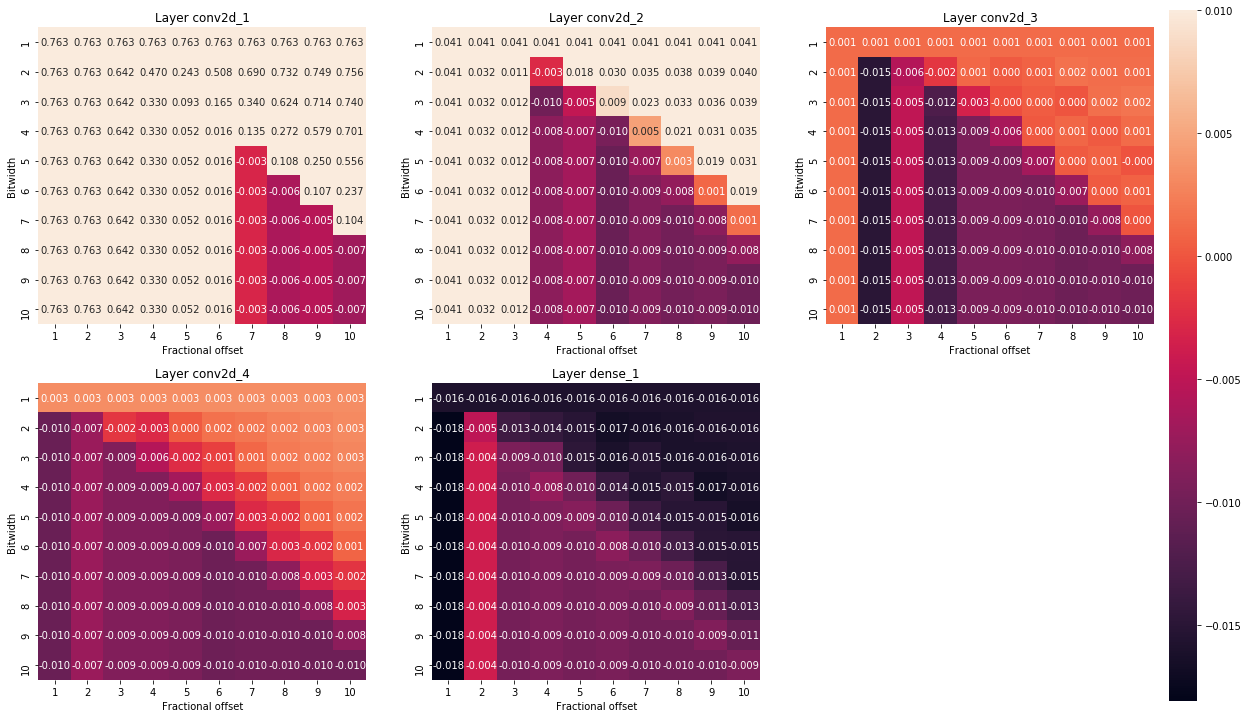

In [12]:
plot_results(scores_b_1, layer_names, 2, 3, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [13]:
keras_cifar.load_model_from_path()
print(keras_cifar.evaluate_accuracy()[1])
keras_cifar = fix_weights_quantization(keras_cifar, w_quant_params)
print(keras_cifar.evaluate_accuracy()[1])
b_quant_params = {
    'conv2d_1': [8, 10],
    'conv2d_3': [2, 2],
    'dense_1': [1, 2],
}
keras_cifar = fix_biases_quantization(keras_cifar, b_quant_params)
print(keras_cifar.evaluate_accuracy()[1])

0.7243
0.7316
0.737


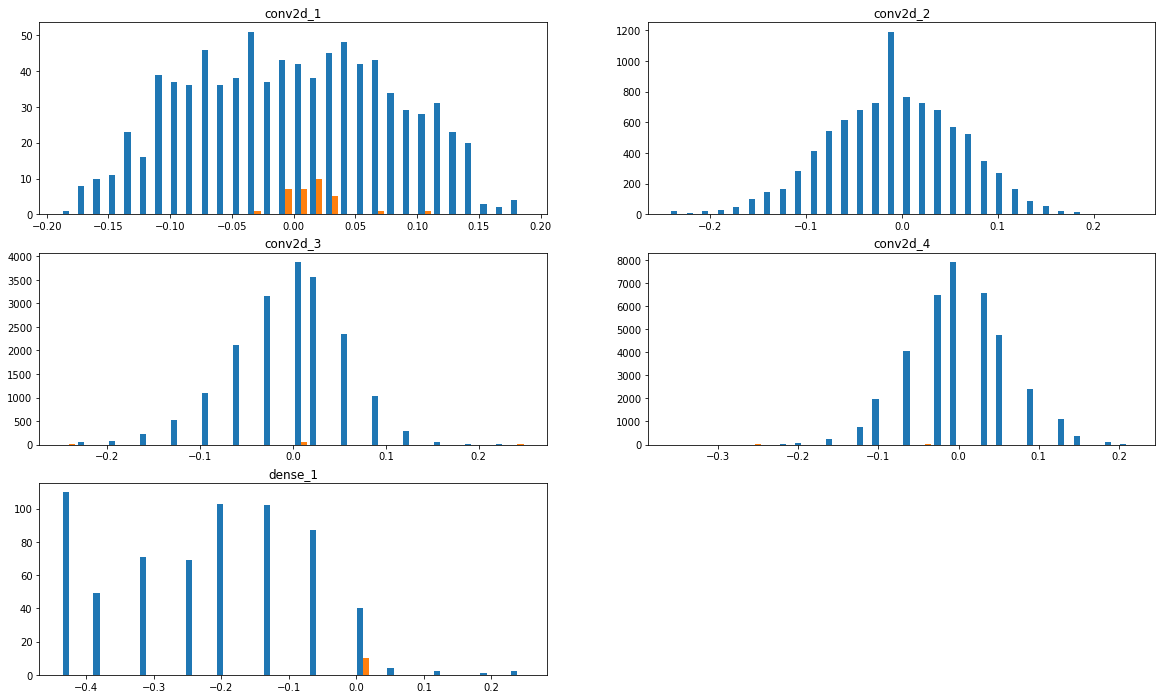

In [27]:
# Quantized set of weights
w = keras_cifar.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [14]:
b_quant_params = {
    'conv2d_1': [6, 8],
}
scores_b_2 = brute_force_analysis_biases(keras_cifar, layer_names[1:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [15]:
np.save(output_path + 'scores_b_2', arr=scores_b_2)

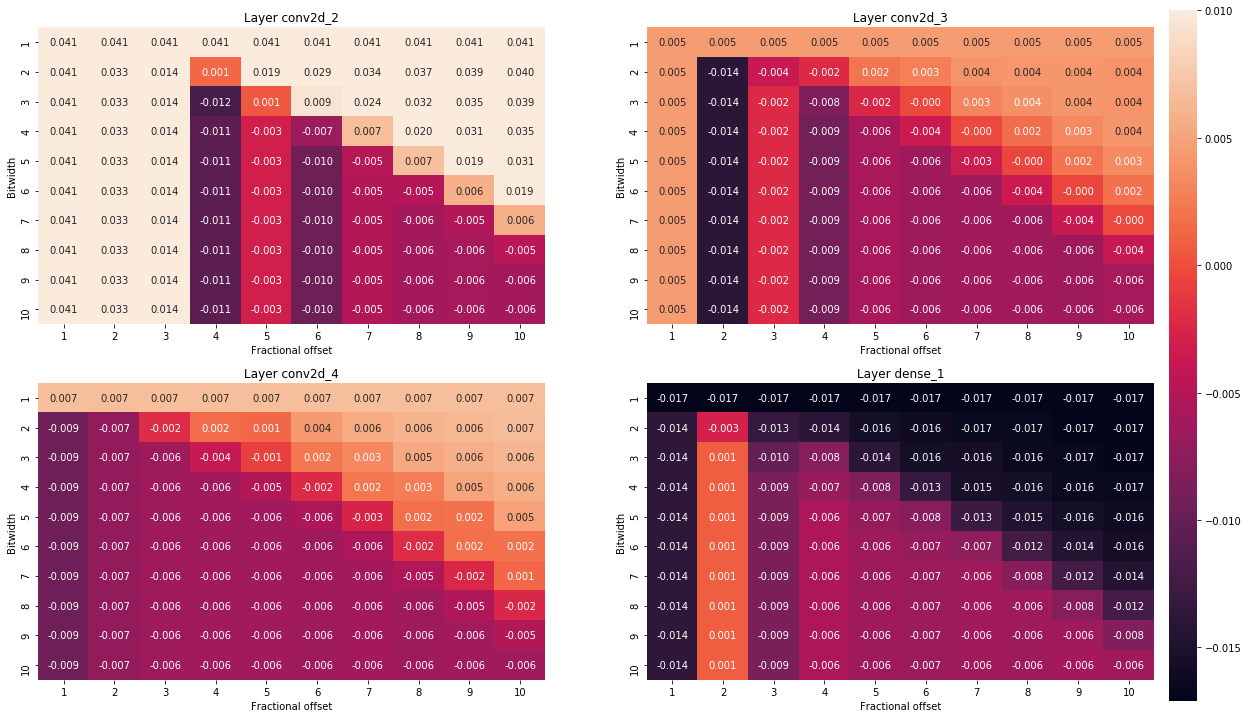

In [16]:
plot_results(scores_b_2, layer_names[1:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [17]:
b_quant_params = {
    'conv2d_1': [6, 8],
    'conv2d_2': [3, 4]
}
scores_b_3 = brute_force_analysis_biases(keras_cifar, layer_names[2:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_3', arr=scores_b_3)

Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


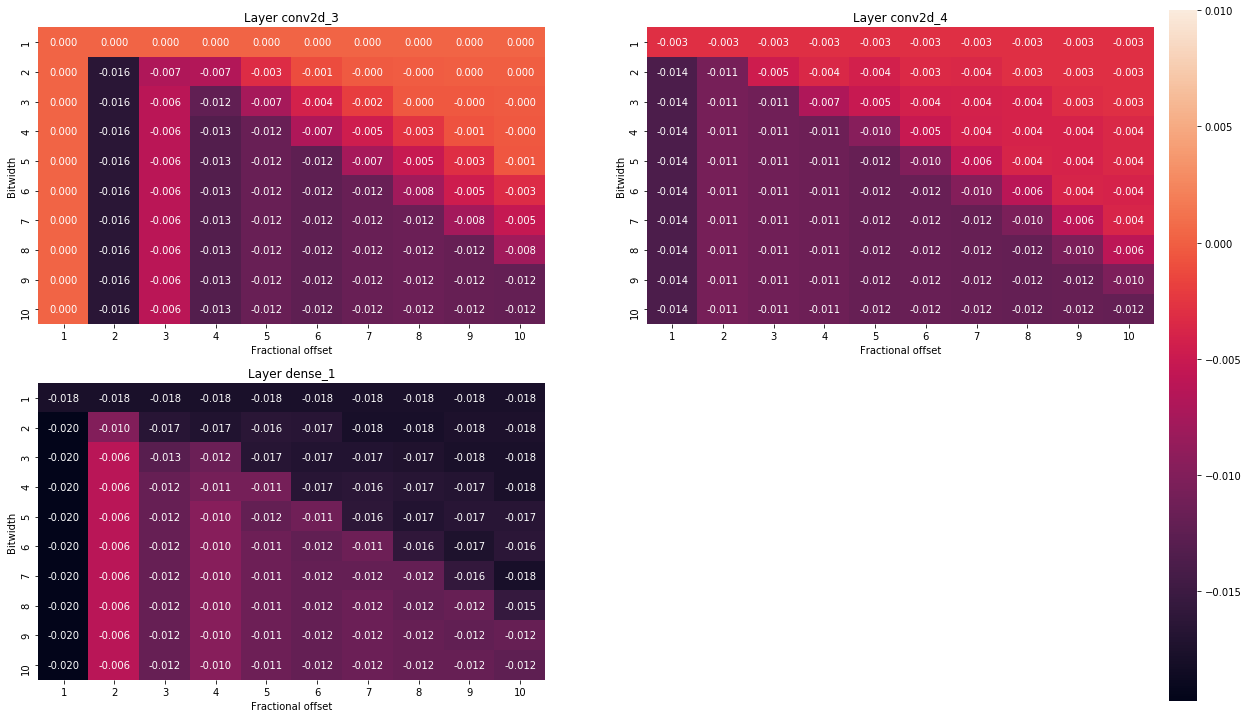

In [18]:
plot_results(scores_b_3, layer_names[2:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [19]:
b_quant_params = {
    'conv2d_1': [6, 8],
    'conv2d_2': [3, 4],
    'conv2d_3': [1, 1],
}
scores_b_4 = brute_force_analysis_biases(keras_cifar, layer_names[3:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_4', arr=scores_b_4)

Layer conv2d_4 done.


Layer dense_1 done.


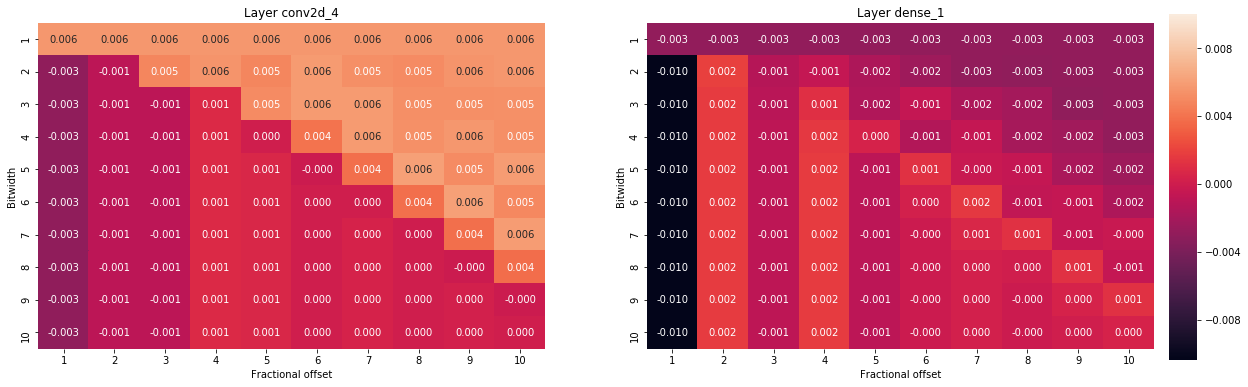

In [20]:
plot_results(scores_b_4, layer_names[3:], 1, 2, (20, 6), 0.8, bw_range, f_range, vmax=0.01)